In [15]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobi_logtools as glt

In [16]:
name = "Track_k_e_2_reruns"
PATH = f".\Experiments\{name}\Logs"

In [17]:
result = glt.parse(PATH+"\*.log")
summary = result.summary()


In [18]:

nl = result.progress("nodelog")
print(nl[~nl['Incumbent'].isna()])
nl.head()

       CurrentNode  RemainingNodes      Obj  Depth  IntInf  Incumbent  \
22          240818         39558.0      NaN   91.0     NaN   0.008915   
23          243589         40544.0      NaN    NaN     NaN   0.008914   
24          244104         40544.0      NaN    NaN     NaN   0.008914   
25          244874         40544.0      NaN    NaN     NaN   0.008914   
26          245417         40568.0      NaN    NaN     NaN   0.008133   
...            ...             ...      ...    ...     ...        ...   
11138      1070354         80486.0      NaN    NaN     NaN   0.000214   
11139      1077338         80835.0  0.00021   77.0    44.0   0.000210   
11140      1091366         51955.0      NaN    NaN     NaN   0.000207   
11141      1091373         36764.0      NaN    NaN     NaN   0.000206   
11142      1091379             NaN      NaN    NaN     NaN   0.000206   

         BestBd       Gap  ItPerNode    Time Pruned NewSolution  \
22     0.000210  0.977000       26.6   67.00    NaN     

c:\Users\sian_\OneDrive\Documents\Thesis\alt_code\pyomo_env\lib\site-packages\gurobi_logtools\api.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  left=pd.concat(progress),


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,Pruned,NewSolution,LogFilePath,LogNumber,Seed,Version
0,0,0.0,0.00021,0.0,56.0,NaN,0.00021,NaN,NaN,0.0,NaN,NaN,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,0,11.0.2
1,0,0.0,0.00021,0.0,56.0,NaN,0.00021,NaN,NaN,0.0,NaN,NaN,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,0,11.0.2
2,0,0.0,0.00021,0.0,71.0,NaN,0.00021,NaN,NaN,0.0,NaN,NaN,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,0,11.0.2
3,0,0.0,0.00021,0.0,71.0,NaN,0.00021,NaN,NaN,0.0,NaN,NaN,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,0,11.0.2
4,0,0.0,0.00021,0.0,105.0,NaN,0.00021,NaN,NaN,0.0,NaN,NaN,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,0,11.0.2


In [44]:
regex_pattern = r'_r(\d+)_c(\d+)\.log'
nl[['Repetition', 'Config']] = nl['LogFilePath'].str.extract(regex_pattern)
nl.head()

nl['Repetition'] = pd.to_numeric(nl['Repetition'])
nl = nl[nl['Repetition'] > 4] # only r5
print(nl['Repetition'].unique())
print(nl)

[5]
       CurrentNode  RemainingNodes      Obj  Depth  IntInf  Incumbent  \
8318             0             0.0  0.00021    0.0    57.0        NaN   
8319             0             0.0  0.00021    0.0    57.0        NaN   
8320             0             0.0  0.00021    0.0   102.0        NaN   
8321             0             0.0  0.00021    0.0   102.0        NaN   
8322             0             0.0  0.00021    0.0   107.0        NaN   
...            ...             ...      ...    ...     ...        ...   
11865     50367745      12001407.0  0.00084  198.0    26.0        NaN   
11866     50442329      12019988.0  0.00021  190.0    33.0        NaN   
11867     50524602      12034777.0      NaN  204.0     NaN        NaN   
11868     50603343      12048160.0  0.00169  205.0    27.0        NaN   
11869     50605152             NaN      NaN    NaN     NaN        NaN   

         BestBd  Gap  ItPerNode     Time      Pruned  NewSolution  \
8318   0.000210  NaN        NaN     0.00         N

In [45]:
print(nl[~nl['NewSolution'].isna()])

Empty DataFrame
Columns: [CurrentNode, RemainingNodes, Obj, Depth, IntInf, Incumbent, BestBd, Gap, ItPerNode, Time, Pruned, NewSolution, LogFilePath, LogNumber, Seed, Version, Repetition, Config]
Index: []


In [46]:
import pandas as pd
import numpy as np

# Ensure columns are numeric, converting non-numeric entries to NaN
for col in ['Time', 'CurrentNode', 'NewSolution', 'Gap', 'Incumbent']:
    nl[col] = pd.to_numeric(nl[col], errors='coerce')

# Define helper functions for individual column aggregations
def time_to_first_feasible(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def solutions(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def final_value(series):
    valid_values = series.dropna()
    return valid_values.iloc[-1] if not valid_values.empty else np.nan

def unique_solutions(series):
    return series.dropna().nunique()

# Aggregate metrics per Config and Repetition
config_metrics = (
    nl.groupby(['Config', 'Repetition']).agg(
        Time_to_optimal=('Time', 'max'),
        Time_to_first_feasible=('Time', time_to_first_feasible),
        Nodes_explored=('CurrentNode', 'max'),
        Solutions_found=('Incumbent', unique_solutions),
        Final_gap=('Gap', final_value),
        Objective_value=('Incumbent', final_value)
    )
    .reset_index()
)

# Average the metrics over the two repetitions for each configuration
average_metrics = config_metrics.groupby('Config').mean(numeric_only=True)

# Display the resulting DataFrame
average_metrics.columns = [
    'Config', 'Avg_Time_to_optimal', 'Avg_Time_to_first_feasible', 'Avg_Nodes_explored',
    'Avg_Solutions_found', 'Avg_Final_gap', 'Avg_Objective_value'
]

average_metrics

,Config,Avg_Time_to_optimal,Avg_Time_to_first_feasible,Avg_Nodes_explored,Avg_Solutions_found,Avg_Final_gap,Avg_Objective_value
Config,,,,,,,
1,5.0,2792.62,0.0,9162223.0,79.0,0.000004,0.000206
2,5.0,3600.09,0.0,11584869.0,43.0,0.397267,0.000341
3,5.0,771.34,0.0,2257005.0,69.0,0.000004,0.000206
4,5.0,790.78,0.0,2358770.0,22.0,0.000000,0.000206
5,5.0,1421.75,0.0,4345318.0,55.0,0.000087,0.000206
6,5.0,384.18,0.0,1091379.0,51.0,0.000064,0.000206
7,5.0,3600.01,0.0,50605152.0,0.0,NaN,NaN


In [47]:
grouped_nl = nl.groupby(['Config', 'Time']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl['Config'].unique()
grouped_nl.head()

Config  Time Incumbent       BestBd     
                    mean std     mean  std
0      1   0.0       NaN NaN  0.00021  0.0
1      1   5.0       NaN NaN  0.00021  NaN
2      1  10.0       NaN NaN  0.00021  NaN
3      1  13.0  0.000979 NaN  0.00021  NaN
4      1  15.0  0.000980 NaN  0.00021  NaN

In [48]:
grouped_nl.columns = ['Config', 'Time', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl["Incumbent_std"] = grouped_nl["Incumbent_std"].fillna(0)
grouped_nl["BestBd_std"] = grouped_nl["BestBd_std"].fillna(0)
grouped_nl.head()

,Config,Time,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0.0,NaN,0.0,0.00021,0.0
1,1,5.0,NaN,0.0,0.00021,0.0
2,1,10.0,NaN,0.0,0.00021,0.0
3,1,13.0,0.000979,0.0,0.00021,0.0
4,1,15.0,0.000980,0.0,0.00021,0.0


In [49]:
ds = grouped_nl.isin([np.inf, -np.inf]).any()
print(ds) 

Config            False
Time              False
Incumbent_mean    False
Incumbent_std     False
BestBd_mean       False
BestBd_std        False
dtype: bool


In [50]:
combinations = {
    'All': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 1},
    'No_MC': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 0},
    'I_only': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 0, 'MHA_MC': 0},
    'LN_only': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 0, 'MHA_MC': 0},
    'Prop_MC': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 1, 'MHA_MC': 1},
    'LN_prop': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 1, 'MHA_MC': 0},
    'None': {'LN_I': 0, 'MHA_I': 0, 'MHA_D': 0, 'MHA_MC': 0},
}


1
2
3
4
5
6
7


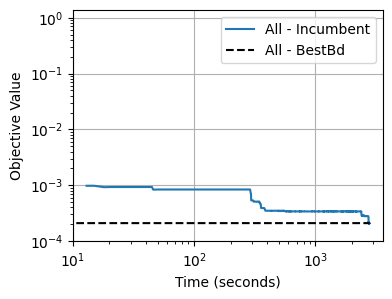

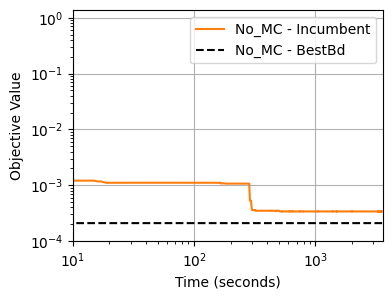

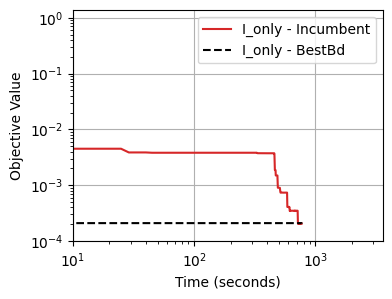

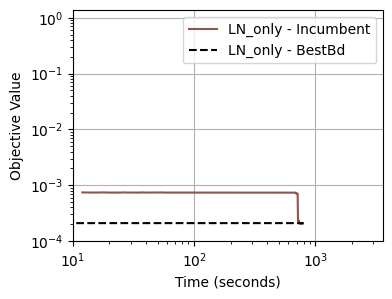

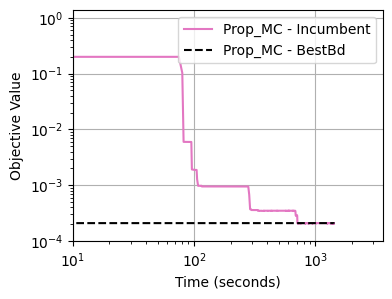

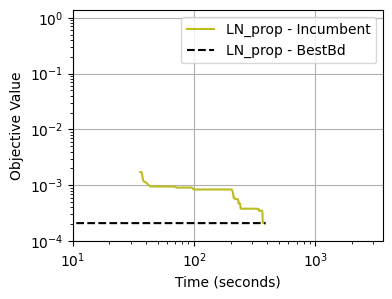

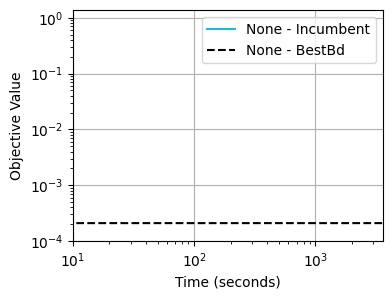

In [55]:
import matplotlib.pyplot as plt

individ = False
if individ:
    grouped_nl = nl
    #combi = grouped_nl[['Config']].drop_duplicates()#grouped_nl[['Repetition', 'Config']].drop_duplicates()
    configs = grouped_nl['Config'].unique()#combi.to_records(index=False).tolist()
else:
    # Find the global min and max values for both the x and y axes across all configurations
    x_min = 10#grouped_nl['Time'].min()
    x_max = grouped_nl['Time'].max()

    y_min = 1e-4 #min(grouped_nl['Incumbent_mean'].min(), grouped_nl['BestBd_mean'].min())
    y_max = max(grouped_nl['Incumbent_mean'].max(), grouped_nl['BestBd_mean'].max())


# Initialize the figure size
colors = plt.get_cmap('tab10', len(grouped_nl['Config'].unique()))
config_names = list(combinations.keys())
    
# Plot each configuration using the same x and y axis limits
for i, config in enumerate(configs):
    print(config)
    plt.figure(i, figsize=(4, 3))
    color = colors(i)

    # Plot Incumbent mean
    if not individ:
        config_data = grouped_nl[grouped_nl['Config'] == config]
        # plt.fill_between(config_data['Time'], 
        #                 config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
        #                 config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
        #                 color=color, alpha=0.5)
        plt.plot(config_data['Time'], config_data['Incumbent_mean'], '-', label=f'{config_names[i]} - Incumbent', color=color)
        #Add shaded area for Incumbent std
        

        # # Plot BestBd mean
        # plt.fill_between(config_data['Time'], 
        #                 config_data['BestBd_mean'] - config_data['BestBd_std'], 
        #                 config_data['BestBd_mean'] + config_data['BestBd_std'], 
        #                 color="black", alpha=0.5)
        plt.plot(config_data['Time'], config_data['BestBd_mean'], linestyle='--', label=f'{config_names[i]} - BestBd', color='k')
    else:
        config_data = grouped_nl[(grouped_nl['Config'] == config)] # & (grouped_nl['Repetition'] == config[0])]
        plt.plot(config_data['Time'], config_data['Incumbent'], linestyle='-', label=f'{config}_{i}')
        plt.plot(config_data['Time'], config_data['BestBd'], linestyle='--', label=f'{config}_{i}')

    
    # Set to log scale
    plt.yscale('log')
    plt.xscale('log')

    # Set the same x and y limits for all plots
    if not individ:   
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

    # Add labels
    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()
    

    # PATH = r"C:\Users\sian_\OneDrive\Documents\Thesis"
    # plt.savefig(PATH+f'\images\{config_names[i]}_time_conv.png')  
    # #plt.show()
     


In [52]:
grouped_nl2 = nl.groupby(['Config', 'CurrentNode']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl2['Config'].unique()
grouped_nl2.columns = ['Config', 'Node', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl2.head()

,Config,Node,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0,NaN,NaN,0.00021,0.0
1,1,13250,NaN,NaN,0.00021,NaN
2,1,27938,NaN,NaN,0.00021,NaN
3,1,41072,0.000979,NaN,0.00021,NaN
4,1,42799,0.000980,NaN,0.00021,NaN


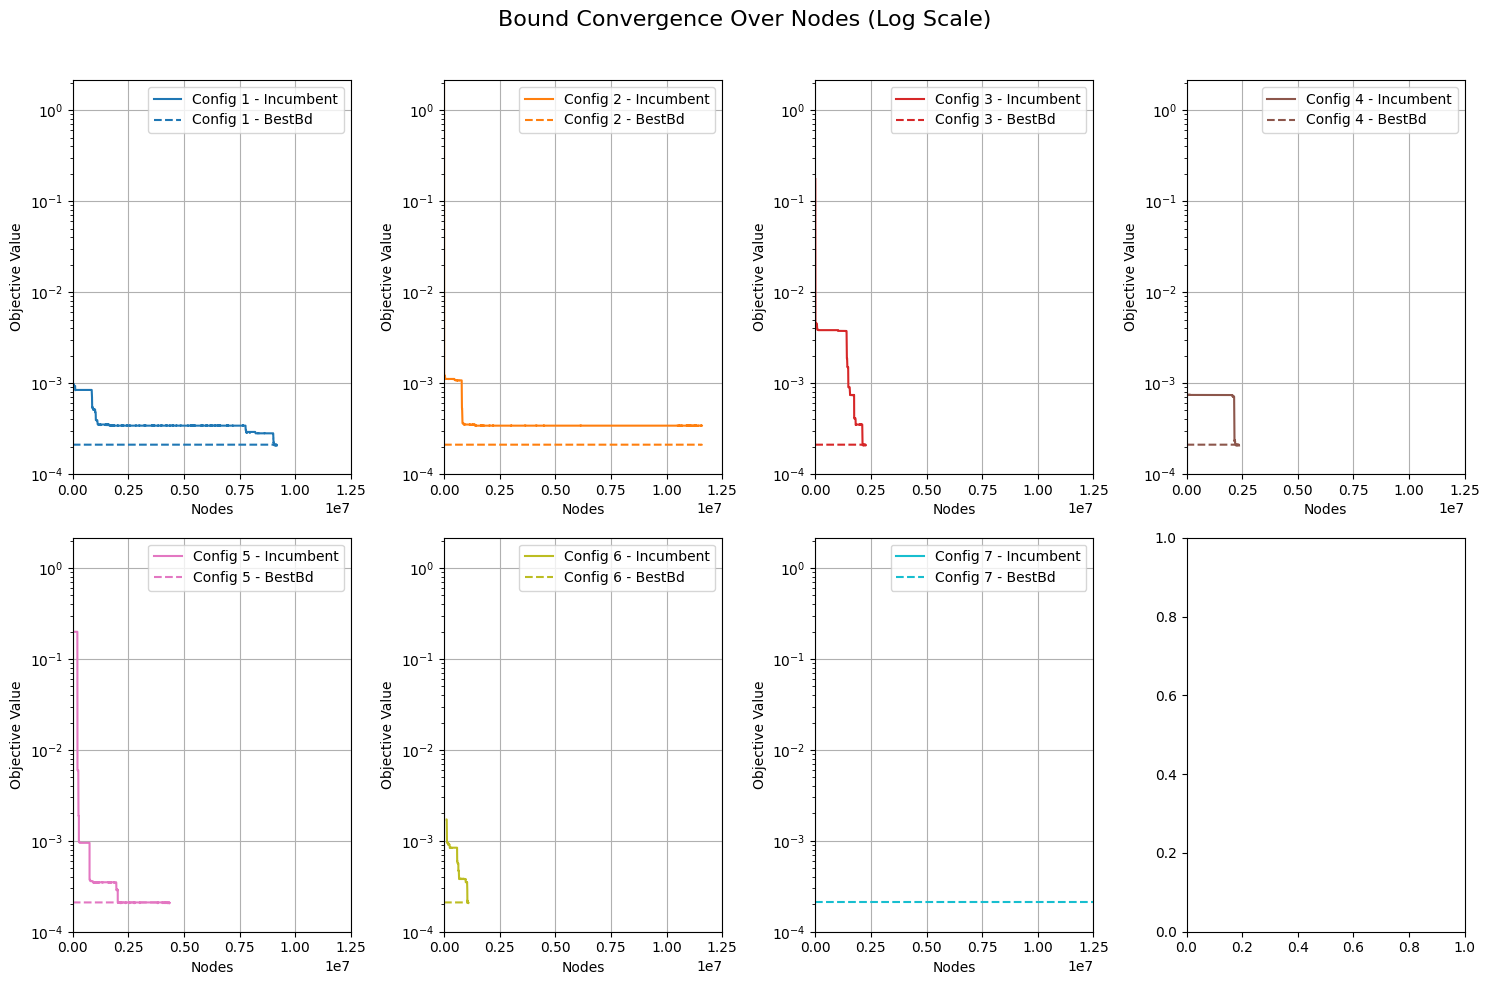

<Figure size 640x480 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the number of subplots based on the number of configurations
num_configs = len(configs)
fig, axes = plt.subplots(nrows=2, ncols=(num_configs + 1) // 2, figsize=(15, 10))  # Adjust subplot grid

# Set the color map for the plots
colors = plt.get_cmap('tab10', num_configs)

# Find the global min and max values for the x and y axes across all configurations
x_min = grouped_nl2['Node'].min()
x_max = 1.25e7
y_min = 1e-4
y_max = max(grouped_nl2['Incumbent_mean'].max(), grouped_nl2['BestBd_mean'].max())

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each configuration in a separate subplot
for i, config in enumerate(configs):
    ax = axes[i]
    config_data = grouped_nl2[grouped_nl2['Config'] == config]
    color = colors(i)

    # Plot Incumbent mean
    ax.plot(config_data['Node'], config_data['Incumbent_mean'], label=f'Config {config} - Incumbent', color=color)
    # Add shaded area for Incumbent std
    ax.fill_between(config_data['Node'], 
                    config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
                    config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
                    color=color, alpha=0.2)

    # Plot BestBd mean
    ax.plot(config_data['Node'], config_data['BestBd_mean'], linestyle='--', label=f'Config {config} - BestBd', color=color)
    # Add shaded area for BestBd std
    ax.fill_between(config_data['Node'], 
                    config_data['BestBd_mean'] - config_data['BestBd_std'], 
                    config_data['BestBd_mean'] + config_data['BestBd_std'], 
                    color=color, alpha=0.2)

    # Set log scale and axis limits
    ax.set_yscale('log')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Add labels and grid
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Objective Value')
    ax.grid(True)
    ax.legend()

# Set the title for the entire figure
fig.suptitle('Bound Convergence Over Nodes (Log Scale)', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

# Optionally, save the figure
PATH = r"C:\Users\sian_\OneDrive\Documents\Thesis"
plt.savefig(PATH + r'\images\bound_convergence_nodes_subplots.png')
